# A network tour to flight delay in the US

Team number: *5*

Team members: *FU Yan, FENG Wentao, SUN Zhaodong, WANG Yunbei*


In this project we explored through our dataset and set up a model predicting delay for given conditions, and based on this model we can give advice on choosing flights on different seasons, airlines and hours. Due to the constraint on difficulties getting whole world delay dataset, and the US is the largest flight country, in our project the delay analysis is mostly based on the US data.

We want to know :
* What will affect mostly on the delay of a flight, could it be departure season, hours or airlines? 
* And can we predict if and how long will a flight delays given certain situations? 
* Or, if some one wants to fly from city A to city B, can we give him or her some advices on choose flights based on the delay rate?


---
## Table of contents

* [Data Exploration](#Data-Exploration)

    - [Openflight](#Openflight)
    
        1. [Overview of Openflight](#Overview-of-Openflight)
    
        2. [Data Analysis for Openflight](#Data-Analysis-for-Openflight)
    
        3. [Create and draw graph for Openflight](#Create-and-draw-graph-for-Openflight) In 1.3 we created graph with airports as nodes and distance as weights. And on the spectral graph we can clearly see regional flights are clustered together.
        
    - [FlightDelay](#Flight-Delay)
    
        1. [Overview of Flight Delay](#Overview-of-Flight-Delay)
        
        2. [Data Cleaning for Flight Delay](#Data-Cleaning-for-Flight-Delay)
        
        This part is used for data processing before machine learning. We selected flights not cancelled and not diverted and converted data into desired data type.

        3. [Data Analysis for Flight Delay](#Data-Analysis-for-Flight-Delay) In 2.3 we analyzed the mean departure and arrival delay on month, departure hour of a day, airlines, departure states and day of a week.

* [Data Exploitation](#Data-Exploitation)
    In this part, we mainly performed:

    * Clustering on whether an airport is averaged to delay (not delay for label -1, delay for label 1);
    * Do machine learning regression to predict delay time in minutes.

    First we defined the averaged delay time of each airports. It was calculated as follow: for specific airport, we calculated the mean arrival delay of all flights starting from it, and defined that delay time < 10 minutes as 'not delay'(labelled as -1), otherwise we labelled as 1.

    - [Clutstering](#Clustering)
    
    And for clustering we tried different methods, including:

        1. [K means clustering](#K-means-clustering);
        2. [Spectral graph clustering](#Spectral-Graph-Clustering);
        3. [Transductive learning](#Transductive-Learning)

    And the **accuracy** for these three methods were **64.3%(5 clusters), 69.4%(threshold eigenvalue is0.004) and 72.3%(recovering from 30% data)** respectively.

    Then we used more features (including month, day of week, hour of day, airline, departure and arrival airport) to set up machine learning model.

    - [Machine Learning](#Machine-Learning)

    Next we set up machine learning model based on decision tree and used this model to predict delay time of certain flights. We used LightGBM, which is a gradient boosting framework that uses tree based learning algorithms. And for features we used departure date, hour, airport, destination airport, air time and distance.

    In this part we included:

        1. [Data preprocessing](#Data-preprocessing)
        2. [Building the model](#Building-the-model)
        3. [Hyperparameter tuning](#Hyperparameter-tuning)
        4. [Recommendation system](#Recommendation-system)

    After model building and hyperparameter tuning, we got a model with prediction **rmse = 2.3**, which worked quite well.
    In this part we showed our recommendation system on how to give advice choosing flights. Given departure date and airports, our recommendation system will return the best combination of airline and departure time, and also the predicted delay minutes. For example, if we want to fly from New York to Chicago on 2019-07-21, our system will return best combination of departure time and airline and predicted delay time.

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import sparse
import scipy.sparse.linalg
from pyunlocbox import functions, solvers

import networkx as nx
import missingno as msno

from math import radians,cos,sin,asin,sqrt
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin

import datetime, warnings, scipy 
import seaborn as sns

import pprint
import joblib
import sklearn.metrics as metrics
from pprint import pprint
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

from TransLearn import *

---

## Data Exploration

- [Openflight](#Openflight)

    1. [Overview of Openflight](#Overview-of-Openflight)

    2. [Data Analysis for Openflight](#Data-Analysis-for-Openflight)

    3. [Create and draw graph for Openflight](#Create-and-draw-graph-for-Openflight) In 1.3 we created graph with airports as nodes and distance as weights. And on the spectral graph we can clearly see regional flights are clustered together.

- [FlightDelay](#Flight-Delay)

    1. [Overview of Flight Delay](#Overview-of-Flight-Delay)

    2. [Data Cleaning for Flight Delay](#Data-Cleaning-for-Flight-Delay)

    This part is used for data processing before machine learning. We selected flights not cancelled and not diverted and converted data into desired data type.

    3. [Data Analysis for Flight Delay](#Data-Analysis-for-Flight-Delay) In 2.3 we analyzed the mean departure and arrival delay on month, departure hour of a day, airlines, departure states and day of a week.


### Openflight
This part is used for data pre-processing and data exploration for the dataset of `OpenFlight` dataset.
1. [Overview of Openflight](#Overview-of-Openflight)

2. [Data Analysis for Openflight](#Data-Analysis-for-Openflight)

3. [Create and draw graph for Openflight](#Create-and-draw-graph-for-Openflight) In 1.3 we created graph with airports as nodes and distance as weights. And on the spectral graph we can clearly see regional flights are clustered together.

---
Go back to [Table of contents](#Table-of-contents)

---

In [2]:
routenames = ['Airline', 'Airline_ID', 'Src_IATA', 'Src_ID', 
            'Des_IATA', 'Des_ID', 'Codeshare', 'Stops', 'Equipment']

routes = pd.read_csv("../routes.dat",header = None,names = routenames,encoding = 'utf-8', na_values='\\N')
routes.dropna(subset=["Airline_ID"], inplace=True)

airlines = pd.read_csv("../airlines.dat",names = ['Airline_ID','Name','Alias','IATA','ICAO','Callsign','Country','Active'])

airports = pd.read_csv("../airports.dat",names = ['Airport_ID','Name','City','Country','IATA','ICAO','Latitude','Longitude',
                                               'Altitude','Timezone','DST','TZ database','Type','Source'], na_values='\\N')

---
### Overview of Openflight

Dataset is obtained from: https://openflights.org/data.html

This OpenFlights/Airline Route Mapper Route Database contains 67,663 routes (EDGES) between 3,321 airports (NODES) on 548 airlines spanning the globe. 

In `routes` data, we have airline, airline ID, source airport IATA code, destination airport IATA code and unique open flight ID, stops and equipment. 

In `airline` data, we have airline ID, airline name, alias, IATA code, ICTO code and country of that airline. 

In `airports` data, we have airport open flight ID, IATA and ICTO code and its latitude and longitude and time zone. Below we use missingno to show the overall data description of each data set.


Below we use `msno` to show the information of dataset. White lines mean missing value. 

In `routes` we have a dataset with size 67184\*9. Columns include airline IATA code, airline unique ID, departure and arrival airport IATA code, code share, stop number of this flight and equipment(the aircraft type).

In [3]:
routes.head(2)

,Airline,Airline_ID,Src_IATA,Src_ID,Des_IATA,Des_ID,Codeshare,Stops,Equipment
0,2B,410.0,AER,2965.0,KZN,2990.0,NaN,0,CR2
1,2B,410.0,ASF,2966.0,KZN,2990.0,NaN,0,CR2


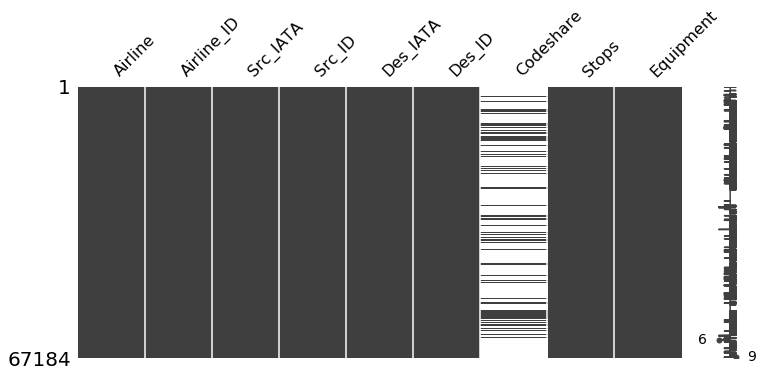

In [4]:
msno.matrix(routes,figsize=(12, 5))#.info()

In `airports` we have a dataset with size 7543\*14. Columns include airport ID, airport name, city, country, IATA and ICAO code of this airport, latitude and longitude, altitude, timezone DST, timezone database, type and data source.

In [5]:
airports.head(2)

,Airport_ID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,TZ database,Type,Source
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.08169,145.391998,5282,10.0,U,Pacific/Port_Moresby,airport,OurAirports
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.20708,145.789001,20,10.0,U,Pacific/Port_Moresby,airport,OurAirports


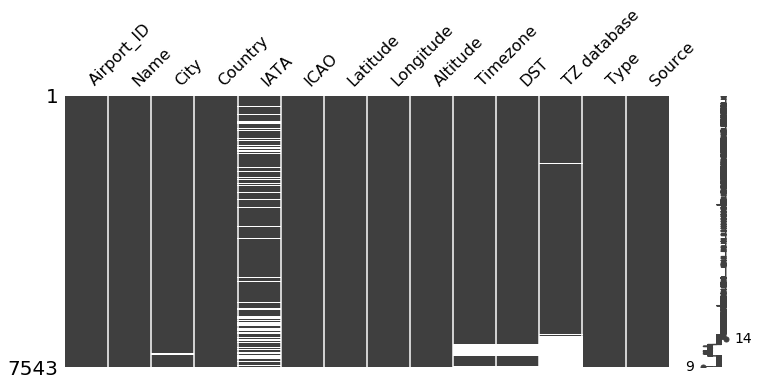

In [6]:
msno.matrix(airports,figsize=(12, 5))#.info()

In `airlines` we have a dataset with size 6162\*8. Columns include airline ID, name, alias, IATA and ICAO code, country and the activeness.

In [7]:
airlines.head(2)

,Airline_ID,Name,Alias,IATA,ICAO,Callsign,Country,Active
0,-1,Unknown,\N,-,NaN,\N,\N,Y
1,1,Private flight,\N,-,NaN,NaN,NaN,Y


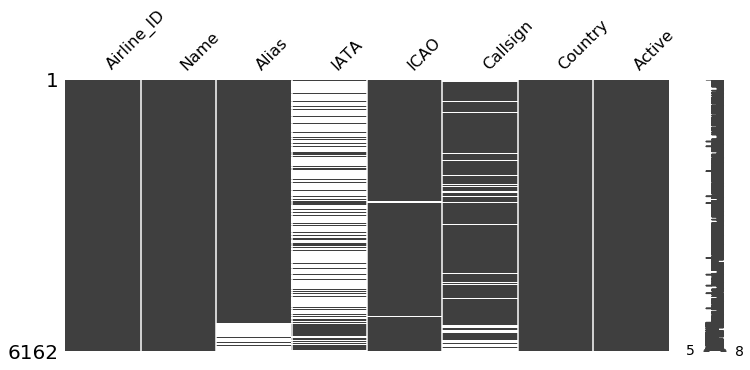

In [8]:
msno.matrix(airlines,figsize=(12, 5))#.info()

---
### Data Analysis for Openflight
In this part we are going to create the adjacency matrix, where the node is airport and the weight of links will be either the routes number between two airports or the maximum capacity of aircrafts on their routes.

In `routes` the column `Equipment` contains the aircraft types of that routes. We calculated the capacity of that route using the maximum of the aircraft capacity. For routes where multi aircrafts are used, we calculated the averaged capacity. And the `Equipment` not in `capacity.xlsx` are mainly helicopters and other small planes, which are not commercially used, so dropping these routes will not affect much.

In [3]:
routes.drop(columns=['Airline','Airline_ID','Codeshare'],inplace=True)
routes.dropna(subset=['Equipment'],inplace=True)
routes.reset_index(level=0, drop=True,inplace=True)

In [4]:
capacity = pd.read_excel('../capacity.xlsx',header=None,index_col=0)
capacity.columns = ['Equipment','Capacity','test']
capacity = capacity[['Equipment','Capacity']]

In [5]:
capacity.dropna(subset=['Capacity'],inplace=True)
capacity.Equipment = capacity.Equipment.astype('str')
capacity.set_index('Equipment',inplace=True)

In [6]:
cap_list = []
for i in range(len(routes)):
    tmp = routes.iloc[i].Equipment#.get_values()
    cap = []
    for equip in tmp.split():
        try:
            cap_tmp = capacity.loc[equip].Capacity
            cap.append(cap_tmp)
        except:
            continue
    cap_list.append(np.mean(cap))

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [7]:
routes['Capacity'] = cap_list
routes.dropna(subset=['Capacity'],inplace=True)

In [14]:
src_cap = routes[['Src_ID','Capacity']].groupby('Src_ID').sum()
des_cap = routes[['Des_ID','Capacity']].groupby('Des_ID').sum()

In [15]:
# merge the capacity ('src_cap' for departure airport;'des_cap' for destination airport)
src_des_cap = pd.concat([src_cap,des_cap], axis=1, sort=True).fillna(0)
src_des_cap.columns = ['Src_cap','Des_cap']
src_des_cap.reset_index(level=0, inplace=True)
src_des_cap.rename(columns={'index':'Airport_ID'},inplace=True)
src_des_cap.head(2)

,Airport_ID,Src_cap,Des_cap
0,1.0,241.666667,241.666667
1,2.0,540.000000,540.000000


In [16]:
portgeo = pd.DataFrame(pd.concat([routes.Src_ID,routes.Des_ID],axis=0).drop_duplicates())
portgeo.rename(columns={0:'Airport_ID'},inplace=True)
portgeo.reset_index(level=0, drop=True,inplace=True)
portgeo = portgeo.merge(src_des_cap,on='Airport_ID')
portgeo.head(5)

,Airport_ID,Src_cap,Des_cap
0,2965.0,3537.333333,3537.333333
1,2966.0,820.000000,820.000000
2,2968.0,2584.000000,2584.000000
3,4029.0,53273.716667,53408.383333
4,6156.0,843.000000,843.000000


In [17]:
# the final .csv containing latittude, longitude, capcity and node index for each airport
portgeo = portgeo.merge(airports[['Name','City','Country','IATA','Latitude','Longitude','Airport_ID']],on='Airport_ID')
portgeo.head(5)

,Airport_ID,Src_cap,Des_cap,Name,City,Country,IATA,Latitude,Longitude
0,2965.0,3537.333333,3537.333333,Sochi International Airport,Sochi,Russia,AER,43.449902,39.956600
1,2966.0,820.000000,820.000000,Astrakhan Airport,Astrakhan,Russia,ASF,46.283298,48.006302
2,2968.0,2584.000000,2584.000000,Chelyabinsk Balandino Airport,Chelyabinsk,Russia,CEK,55.305801,61.503300
3,4029.0,53273.716667,53408.383333,Domodedovo International Airport,Moscow,Russia,DME,55.408798,37.906300
4,6156.0,843.000000,843.000000,Belgorod International Airport,Belgorod,Russia,EGO,50.643799,36.590099


In [10]:
#portgeo.to_csv('../portgeo.csv',index=False)
portgeo = pd.read_csv('../portgeo.csv')

In [36]:
portgeo['total_cap'] = portgeo.Src_cap.get_values() + portgeo.Des_cap.get_values()

Here we show the top 10 largest capacity airports. Comparing the list to the real top 10 busiest airports worldwide, we can see that two list overlap a lot.

In [38]:
portgeo.sort_values(by='total_cap',ascending=False).head(10)

,Airport_ID,Src_cap,Des_cap,Name,City,Country,IATA,Latitude,Longitude,total_cap
423,507.0,143397.716667,142622.800000,London Heathrow Airport,London,United Kingdom,LHR,51.470600,-0.461941,286020.516667
159,3682.0,141866.095238,139436.509524,Hartsfield Jackson Atlanta International Airport,Atlanta,United States,ATL,33.636700,-84.428101,281302.604762
266,3364.0,115172.759524,114819.426190,Beijing Capital International Airport,Beijing,China,PEK,40.080101,116.584999,229992.185714
397,1382.0,113329.350000,111403.600000,Charles de Gaulle International Airport,Paris,France,CDG,49.012798,2.550000,224732.950000
409,340.0,106306.785714,105942.619048,Frankfurt am Main Airport,Frankfurt,Germany,FRA,50.033333,8.570556,212249.404762
326,3797.0,99766.800000,100187.400000,John F Kennedy International Airport,New York,United States,JFK,40.639801,-73.778900,199954.200000
298,3484.0,95866.950000,96717.783333,Los Angeles International Airport,Los Angeles,United States,LAX,33.942501,-118.407997,192584.733333
242,3930.0,94953.850000,95024.850000,Incheon International Airport,Seoul,South Korea,ICN,37.469101,126.450996,189978.700000
142,3316.0,94079.000000,95077.833333,Singapore Changi Airport,Singapore,Singapore,SIN,1.350190,103.994003,189156.833333
128,3885.0,88661.621429,88772.954762,Suvarnabhumi Airport,Bangkok,Thailand,BKK,13.681100,100.747002,177434.576190


And we can see that the US is the country with largest flight passengers.

In [40]:
portgeo.groupby('Country')['total_cap'].sum().sort_values(ascending=False).head(5)

Country
United States     3.536720e+06
China             2.619732e+06
United Kingdom    9.498741e+05
Spain             8.445502e+05
Germany           7.737909e+05
Name: total_cap, dtype: float64

---
### Create and draw graph for Openflight
Below we created the graph using airports as nodes, distance of airports as weights.

In [8]:
df_tmp = routes.groupby(['Src_IATA','Des_IATA'])['Capacity'].agg(['count','sum']).reset_index()

In [11]:
df_tmp = df_tmp.merge(portgeo[['IATA','Latitude','Longitude']],left_on='Src_IATA',right_on='IATA').drop(columns='IATA')
df_tmp = df_tmp.merge(portgeo[['IATA','Latitude','Longitude']],\
                      left_on='Des_IATA',right_on='IATA',suffixes=('_Src', '_Des')).drop(columns='IATA')
df_tmp.head()

,Src_IATA,Des_IATA,count,sum,Latitude_Src,Longitude_Src,Latitude_Des,Longitude_Des
0,AAE,ALG,1,124.333333,36.822201,7.809174,36.691002,3.21541
1,ABJ,ALG,1,189.000000,5.261390,-3.926290,36.691002,3.21541
2,ALC,ALG,1,110.000000,38.282200,-0.558156,36.691002,3.21541
3,AMM,ALG,2,247.000000,31.722601,35.993198,36.691002,3.21541
4,AZR,ALG,1,74.000000,27.837601,-0.186414,36.691002,3.21541


We calculated distance using this formula:

$$ S = 2* arcsin\sqrt{sin^2\frac{a}{2}+cos(Lat1)*cos(Lat2)*sin^2\frac{b}{2}} * Earth Radius $$
$$ a = Lat1-Lat2, b = Lon1 - Lon2 $$

In [13]:
def CalDis(point_1_lat, point_1_lon, point_2_lat, point_2_lon):
    # approximate radius of earth in km
    R = 6378.137 # earth radius

    lat1 = radians(float(point_1_lat))
    lon1 = radians(float(point_1_lon))
    lat2 = radians(float(point_2_lat))
    lon2 = radians(float(point_2_lon))

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * asin(sqrt(a))

    distance = R * c
    return np.round(distance)

In [14]:
df_tmp['Distance'] = df_tmp.apply(lambda row:CalDis(row['Latitude_Src'],row['Longitude_Src'],
                                                    row['Latitude_Des'],row['Longitude_Des']),axis=1)
df_tmp['Distance'] = df_tmp['Distance'].clip_upper(2000)

In [55]:
# df_tmp.to_csv('LatLonDis.csv',index=False)

In [56]:
df_tmp.head()

,Src_IATA,Des_IATA,count,sum,Latitude_Src,Longitude_Src,Latitude_Des,Longitude_Des,Distance,weight
0,AAE,ALG,1,124.333333,36.822201,7.809174,36.691002,3.21541,410.0,0.996103
1,ABJ,ALG,1,189.000000,5.261390,-3.926290,36.691002,3.21541,2000.0,0.990706
2,ALC,ALG,1,110.000000,38.282200,-0.558156,36.691002,3.21541,377.0,0.996989
3,AMM,ALG,2,247.000000,31.722601,35.993198,36.691002,3.21541,2000.0,0.983935
4,AZR,ALG,1,74.000000,27.837601,-0.186414,36.691002,3.21541,1036.0,0.998711


We first normalized the distance feature and then converted distance to weights with a Gaussian kernel,the longer distance the smaller weights:
$$ W = exp(-\frac{Distance^2}{\delta ^2}) $$ 

In [15]:
df_tmp['weight'] = df_tmp['Distance'].copy()
df_tmp.weight=(df_tmp.weight-df_tmp.weight.min())/(df_tmp.weight.max()-df_tmp.weight.min())

delta = 0.2
df_tmp.weight = np.exp(-np.square(df_tmp.weight)/delta)

In our first thought, the airports in same region should have stronger connections and they may show same properties (eg. average delay time in our project), because airports in same region should have similar background (eg. flight policies, infrastructure level) and we can analyze different conditions on airports from similar background. 

Then we created our graph with airports as nodes, Gaussian kernel as weights. And we plotted the eigenvalues of our graph, noticing that at 97-th eigenvalue there was a jump. So we performed k-means clustering with k=97 and used the predicted k means result as label over our graph. 

In [16]:
G=nx.from_pandas_edgelist(df_tmp,'Src_IATA','Des_IATA', edge_attr='weight')

In [17]:
L = nx.normalized_laplacian_matrix(G)
e, U = sparse.linalg.eigsh(L, k=100, which='SA')

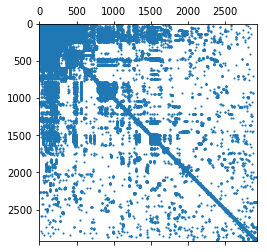

In [19]:
plt.spy(L,markersize=1)
plt.show()

In [103]:
def NumKMeans(x):
    """
    This function is used to return the index where jump happens.
    """
    x1 = x[:-1]
    x2 = x[1:]
    y = x2 - x1
    return np.argmax(y)+1

In [104]:
n_k_means = NumKMeans(e)
n_k_means

97

Text(0.5,1,'top 100 eigenvalue of our graph')

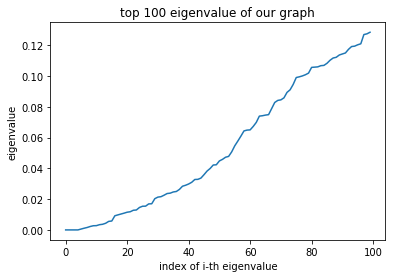

In [105]:
plt.plot(e)
plt.xlabel('index of i-th eigenvalue')
plt.ylabel('eigenvalue')
plt.title('top 100 eigenvalue of our graph')

In [106]:
X = U[:,0:n_k_means]

k_means = KMeans(init='k-means++', n_clusters=n_k_means, n_init=10)
k_means.fit(X)

k_means_cluster_centers = np.sort(k_means.cluster_centers_, axis=0)
k_means_labels = pairwise_distances_argmin(X, k_means_cluster_centers)

Text(0.5,1,'Spectral graph of first and second eigenvectors (zoomed in)')

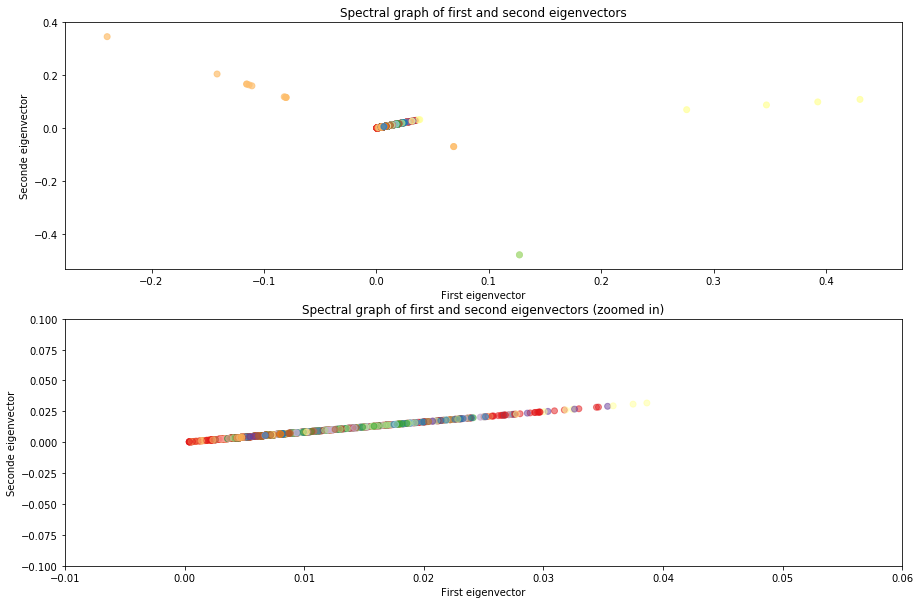

In [108]:
cmap = plt.get_cmap('Paired',n_k_means)

fig, ax = plt.subplots(2,1,figsize=(15,10))
ax[0].scatter(U[:,1],U[:,2],c=k_means_labels,alpha=0.7,cmap=cmap)
ax[0].set_xlabel('First eigenvector')
ax[0].set_ylabel('Seconde eigenvector')
ax[0].set_title('Spectral graph of first and second eigenvectors')
#plt.colorbar()
ax[1].scatter(U[:,1],U[:,2],c=k_means_labels,alpha=0.5,cmap=cmap)
ax[1].set_xlabel('First eigenvector')
ax[1].set_ylabel('Seconde eigenvector')
ax[1].set_xlim(-0.01,0.06)
ax[1].set_ylim(-0.1,0.1)
ax[1].set_title('Spectral graph of first and second eigenvectors (zoomed in)')


In [92]:
pos_dict = {}
portgeo.set_index('IATA',inplace=True)
for node_IATA in list(G.node):
    try:
        longitude = portgeo.loc[node_IATA].Longitude
        latitude = portgeo.loc[node_IATA].Latitude
    except:
        longitude = 0
        latitude = 0        
    pos_dict[node_IATA] = longitude,latitude
portgeo.reset_index(inplace=True)

The drawing shows that approximately airports are clustered to their neighbourhoods, and we can see the cluster approximately shows the continents and countries ( eg Eastern Asia, Europe, US and Africa).

**We may say that, the world is connected, but it is still separated into small regions.**

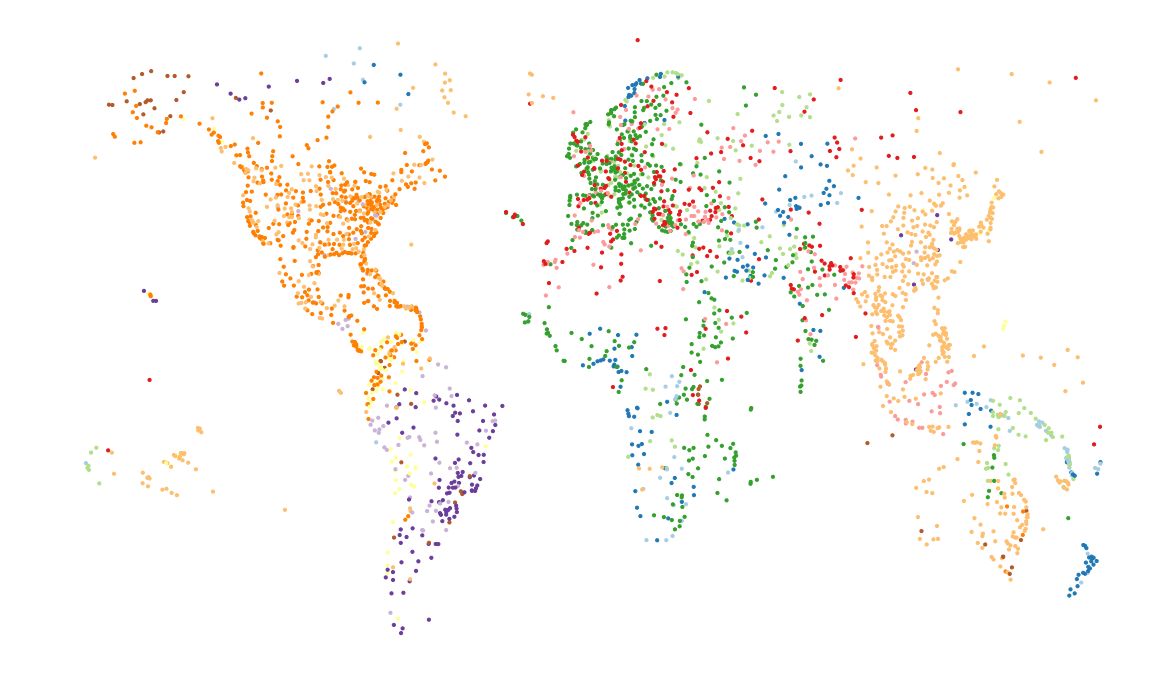

In [99]:
fig, ax = plt.subplots(figsize=(20,12))

nx.draw(G,pos=pos_dict,node_size=10,width=0,node_color=k_means_labels,cmap=cmap)

---
Go back to [Table of contents](#Table-of-contents)

----

### Flight Delay
This part is for data pre-processing and data exploration for the dataset of `2015 Flight Delays and Cancellations` dataset.
1. [Overview of Flight Delay](#Overview-of-Flight-Delay)

2. [Data Cleaning for Flight Delay](#Data-Cleaning-for-Flight-Delay)

This part is used for data processing before machine learning. We selected flights not cancelled and not diverted and converted data into desired data type.

3. [Data Analysis for Flight Delay](#Data-Analysis-for-Flight-Delay) In 2.3 we analyzed the mean departure and arrival delay on month, departure hour of a day, airlines, departure states and day of a week.

4. [Spectral Graph Analysis ](#Spectral-Graph-Analysis ) 

---
Go back to [Table of contents](#Table-of-contents)

---

In [5]:
airlines = pd.read_csv('airlines.csv')
airports = pd.read_csv('airports.csv')
flights = pd.read_csv('flights.csv',low_memory=False)
#dateCols = ['DATE','SCHEDULED_DEPARTURE','SCHEDULED_ARRIVAL','DEPARTURE_TIME','ARRIVAL_TIME']
#flights = pd.read_csv('flights_clean.csv',low_memory=False)
abbr_companies = airlines.set_index('IATA_CODE')['AIRLINE'].to_dict()

---
### Overview of Flight Delay

As the US is the busiest country with largest capacity, it is typical to look into details of the US and then apply similar method to other regions.
From Kaggle we downloaded a new dataset containing delay informat ion of US flight routes.

https://www.kaggle.com/usdot/flight-delays#flights.csv

This dataset is collected by the U.S. Department of Transportation's (DOT) Bureau of Transportation Statistics, who tracks the on-time performance of domestic flights operated by large air carriers from 01/01/2015 to 31/21/2015. And features information flight number, airline, departure and arrival time, delay time, air time, distance, origin and destination airport and delay reason( not for all delayed flights). Also, the documents including relationship of IATA code and full information of airports and airlines are given. 


`airlines` contains the IATA code and full name of 14 main airports in US.

In [5]:
airlines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 2 columns):
IATA_CODE    14 non-null object
AIRLINE      14 non-null object
dtypes: object(2)
memory usage: 304.0+ bytes


In [4]:
airlines.head(2)

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.


`airports` contains full information of 322 airports (IATA code, airport name, city, state, country, latitude and longitude), and misses three airports' latitude and longitude. After googling we found latitude and longitude of these three airports: ECP 30 -85; PBG 44 -73; UST 29 -81.

In [6]:
airports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 7 columns):
IATA_CODE    322 non-null object
AIRPORT      322 non-null object
CITY         322 non-null object
STATE        322 non-null object
COUNTRY      322 non-null object
LATITUDE     319 non-null float64
LONGITUDE    319 non-null float64
dtypes: float64(2), object(5)
memory usage: 17.7+ KB


In [16]:
# airports missing latitude and longitude information
airports.loc[airports.LATITUDE.isnull()]

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
96,ECP,Northwest Florida Beaches International Airport,Panama City,FL,USA,NaN,NaN
234,PBG,Plattsburgh International Airport,Plattsburgh,NY,USA,NaN,NaN
313,UST,Northeast Florida Regional Airport (St. August...,St. Augustine,FL,USA,NaN,NaN


In [7]:
airports.head(2)

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.4404
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.6819


In [24]:
# fill in missing value found from google
airports.at[96,'LATITUDE'] = 30
airports.at[96,'LONGITUDE'] = -85
airports.at[234,'LATITUDE'] = 44
airports.at[234,'LONGITUDE'] = -73
airports.at[313,'LATITUDE'] = 29
airports.at[313,'LONGITUDE'] = -81

In [26]:
airports.to_csv('airports.csv',index=False)

Below we use msno to show the information of `flights`. White lines mean Nan value. We can see `flights` has 32 columns and 5714008 samples, columns include flight date, airline, origin and destination airport, flight time information, cancellation and reason and delay reason.

We can see there are large missing values in cancellation and delay reasons, so we are not going to use `reason` as our features in later machine learning part.

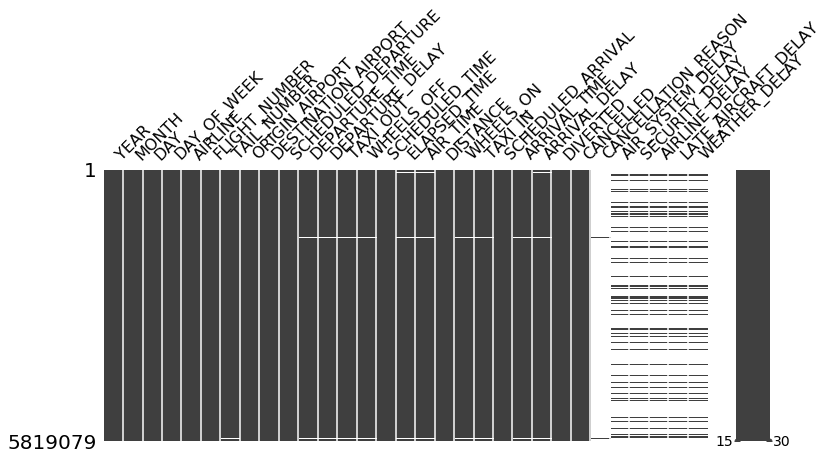

In [14]:
msno.matrix(flights,figsize=(12, 5))#.info()

In [8]:
flights.head(2)

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,DATE
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,00:05:00,...,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,00:10:00,...,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01


---
### Data Cleaning for Flight Delay
This part is used for data processing before machine learning. What we did here:

1. First we selected flights not cancelled and not diverted.

2. We noticed in origin dataset, the IATA code of airports in October 2015 is using 5-digit number but not the correct 3-letter code. So we first converted these 5-digit number back to 3-letter IATA code.

3. We converted the time string in original dataset into time.time type;

4. Merging `airport` and flights we merged location of origin and destination airports to each flight.

1. We are not interested in cancelled flights and also, we want to use destination airport as our features, so we do not take diverted flights into account (a diverted flight means the flight does not arrive at the scheduled airport).

In [3]:
flights = flights.loc[flights.CANCELLED==0]
flights = flights.loc[flights.DIVERTED==0]
flights.reset_index(drop=True,inplace=True)

In [4]:
flights.columns

Index(['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER',
       'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
       'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'],
      dtype='object')

2. Here we converted the 5-digit number in October 2015 into 3-letter IATA code.

In [5]:
df_aircode1 = pd.read_csv('./data/L_AIRPORT.csv')
df_aircode2 = pd.read_csv('./data/L_AIRPORT_ID.csv')
df_aircode1 = df_aircode1.reset_index()
df_aircode2 = df_aircode2.reset_index()
df_aircodes = pd.merge(df_aircode1,df_aircode2,on='Description')
aircode_dict = dict(zip(df_aircodes['Code_y'].astype(str),df_aircodes['Code_x']))

# # Make sure all Origin and departing airports are strings
flights['ORIGIN_AIRPORT'] = flights['ORIGIN_AIRPORT'].values.astype(str)
flights['DESTINATION_AIRPORT'] = flights['DESTINATION_AIRPORT'].values.astype(str)

In [10]:
df = flights.copy()
five_digit = flights.loc[flights.MONTH==10].ORIGIN_AIRPORT.unique()

for i in range(len(five_digit)):
    to_replace = five_digit[i]
    value = aircode_dict[five_digit[i]]
    df.ORIGIN_AIRPORT = df.ORIGIN_AIRPORT.replace(to_replace, value)
    df.DESTINATION_AIRPORT = df.DESTINATION_AIRPORT.replace(to_replace, value)
    print(i,'replaced',to_replace,'with',value)

0 replaced 14747 with SEA
1 replaced 14771 with SFO
2 replaced 12889 with LAS
3 replaced 12892 with LAX
4 replaced 14869 with SLC
5 replaced 10299 with ANC
6 replaced 11292 with DEN
7 replaced 14107 with PHX
8 replaced 11630 with FAI
9 replaced 10732 with BQN
10 replaced 14254 with PSE
11 replaced 10141 with ABR
12 replaced 10627 with BIS
13 replaced 11982 with GRK
14 replaced 12173 with HNL
15 replaced 13930 with ORD
16 replaced 14683 with SAT
17 replaced 12266 with IAH
18 replaced 11618 with EWR
19 replaced 10721 with BOS
20 replaced 13487 with MSP
21 replaced 11884 with GEG
22 replaced 15919 with XNA
23 replaced 13851 with OKC
24 replaced 11111 with COU
25 replaced 10693 with BNA
26 replaced 12191 with HOU
27 replaced 14783 with SGF
28 replaced 15016 with STL
29 replaced 14487 with RDD
30 replaced 10423 with BSM
31 replaced 15370 with TUL
32 replaced 11953 with GNV
33 replaced 13891 with ONT
34 replaced 15376 with TUS
35 replaced 11778 with FSM
36 replaced 11278 with DCA
37 replaced

297 replaced 13541 with MVY
298 replaced 15027 with STX
299 replaced 10170 with ADQ
300 replaced 10165 with ADK
301 replaced 15497 with UST
302 replaced 12265 with IAG
303 replaced 14222 with PPG
304 replaced 14025 with PBG
305 replaced 13502 with MTJ


3. We converted the time string into datetime.time type.

In [13]:
flights = df.copy()

In [14]:
# Function that convert the 'HHMM' string to datetime.time
def format_heure(chaine):
    if pd.isnull(chaine):
        return np.nan
    else:
        if chaine == 2400: chaine = 0
        chaine = "{0:04d}".format(int(chaine))
        heure = datetime.time(int(chaine[0:2]), int(chaine[2:4]))
        return heure
    return pd.Series(liste)

In [15]:
flights['DATE'] = pd.to_datetime(flights[['YEAR','MONTH', 'DAY']])
flights['SCHEDULED_DEPARTURE'] = flights['SCHEDULED_DEPARTURE'].apply(format_heure)
flights['SCHEDULED_ARRIVAL'] = flights['SCHEDULED_ARRIVAL'].apply(format_heure)
flights['DEPARTURE_TIME'] = flights['DEPARTURE_TIME'].apply(format_heure)
flights['ARRIVAL_TIME'] = flights['ARRIVAL_TIME'].apply(format_heure)

In [16]:
# flights.to_csv('flights_clean.csv',index=False)

In [3]:
flights = flights[['DATE','MONTH','DAY','DAY_OF_WEEK',
                  'AIRLINE','FLIGHT_NUMBER','ORIGIN_AIRPORT','DESTINATION_AIRPORT',
                  'SCHEDULED_DEPARTURE','SCHEDULED_ARRIVAL','DEPARTURE_DELAY','ARRIVAL_DELAY',
                  'AIR_TIME','DISTANCE']]

In [29]:
flights['DATE'] = pd.to_datetime(flights['DATE'])
flights['SCHEDULED_DEPARTURE'] = pd.to_datetime(flights['SCHEDULED_DEPARTURE'],format="%H:%M:%S").dt.time

In [30]:
def hr_func(ts):
    return ts.hour
flights['time_hour'] = flights['SCHEDULED_DEPARTURE'].apply(hr_func)

In [7]:
df = flights.copy()
df_city = df.merge(airports[['IATA_CODE','CITY','STATE']],left_on='ORIGIN_AIRPORT',right_on='IATA_CODE')
df_city.rename(columns={'CITY':'DEPARTURE_CITY','STATE':'DEPARTURE_STATE'},inplace=True)
df_city.drop(columns='IATA_CODE',inplace=True)
df_city = df_city.merge(airports[['IATA_CODE','CITY','STATE']],left_on='DESTINATION_AIRPORT',right_on='IATA_CODE')
df_city.rename(columns={'CITY':'DESTINATION_CITY','STATE':'DESTINATION_STATE'},inplace=True)
df_city.drop(columns='IATA_CODE',inplace=True)
flights = df_city

After all pre-processing we got the data set as below:

In [8]:
# flights.to_csv('flights_new.csv',index=False)
flights.head()

,DATE,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,DEPARTURE_DELAY,ARRIVAL_DELAY,AIR_TIME,DISTANCE,time_hour,DEPARTURE_CITY,DEPARTURE_STATE,DESTINATION_CITY,DESTINATION_STATE
0,2015-01-01,1,1,4,AS,98,ANC,SEA,00:05:00,04:30:00,-11.0,-22.0,169.0,1448,0,Anchorage,AK,Seattle,WA
1,2015-01-01,1,1,4,AS,108,ANC,SEA,00:45:00,05:09:00,-4.0,-14.0,173.0,1448,0,Anchorage,AK,Seattle,WA
2,2015-01-01,1,1,4,DL,1560,ANC,SEA,00:45:00,05:15:00,-14.0,-24.0,171.0,1448,0,Anchorage,AK,Seattle,WA
3,2015-01-01,1,1,4,AS,134,ANC,SEA,01:55:00,06:33:00,-15.0,-35.0,170.0,1448,1,Anchorage,AK,Seattle,WA
4,2015-01-01,1,1,4,AS,114,ANC,SEA,02:20:00,06:40:00,-11.0,-12.0,176.0,1448,2,Anchorage,AK,Seattle,WA


---
### Data Analysis for Flight Delay
In this part, we wanted to explore the influence of different features on delay time. We plotted the averaged delay time( both depature delay time and arrival delay time) on each feature:

1. Different airline companies;
2. Day of week (Monday, Tuesday, Wednesday etc.);
3. Month (January, Feburary etc.);
4. Time of a day(from 0 to 23 per hour);
5. Depature city or state.

And we can see that with different airline, day of week, month, time of a day and depature city, the delay time differs. And generally, the arrival delay time would be shorter than departure delay time, which means the airline will speed up a little to counterback depacture delay. 

1. First we looked at the averaged delay time of different airline. Generally Hawaiian Airlines and Alaska Airlines have lowest delay time. And when we considered the counts of delay flights (here we used 5 and 30 minutes thresholding not delay, small delay and heavy delay). And we can see Southwest airline serves most flights and also most delays; Hawaiian airline serves least flights and thus least delays.

In [3]:
flights = pd.read_csv('flights_new.csv')

Text(0.5,1,'Mean delay time grouped by airlines')

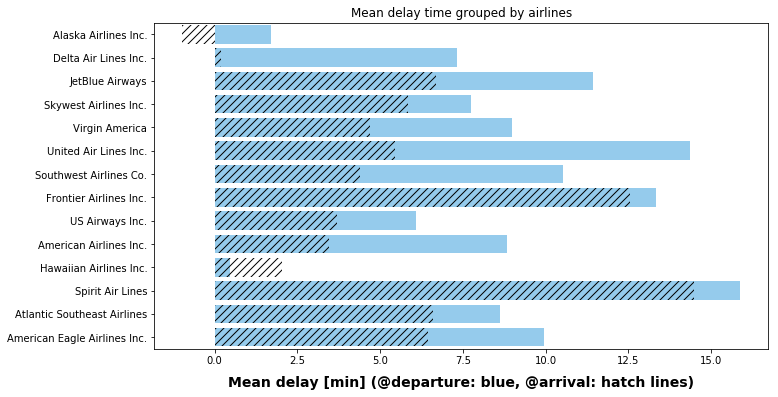

In [7]:
df = flights.copy()
fig = plt.figure(1, figsize=(11,6))
ax = sns.barplot(x="DEPARTURE_DELAY", y="AIRLINE", data=df, color="lightskyblue", ci=None)
ax = sns.barplot(x="ARRIVAL_DELAY", y="AIRLINE", data=df, color="r", hatch = '///',
                 alpha = 0.0, ci=None)
labels = [abbr_companies[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
ax.yaxis.label.set_visible(False)
plt.xlabel('Mean delay [min] (@departure: blue, @arrival: hatch lines)',
           fontsize=14, weight = 'bold', labelpad=10);
plt.title('Mean delay time grouped by airlines')

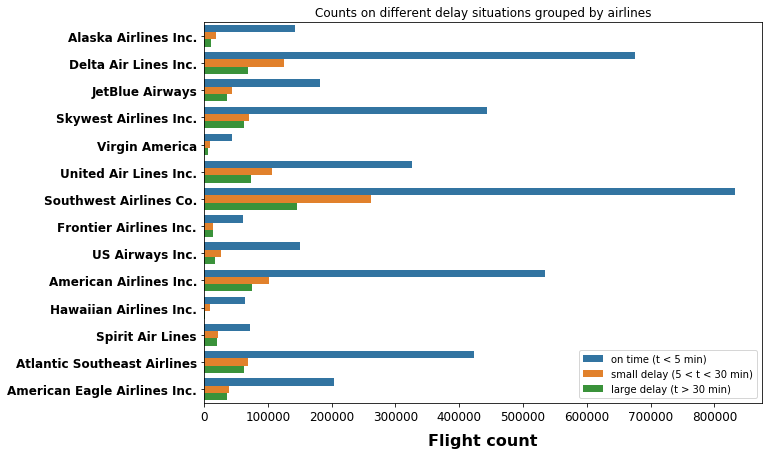

In [9]:
#_____________________________________________
# Function that define how delays are grouped
delay_type = lambda x:((0,1)[x > 5],2)[x > 30]
df['DELAY_LEVEL'] = df['DEPARTURE_DELAY'].apply(delay_type)
#____________________________________________________
fig = plt.figure(1, figsize=(10,7))
ax = sns.countplot(y="AIRLINE", hue='DELAY_LEVEL', data=df)
#____________________________________________________________________________________
# We replace the abbreviations by the full names of the companies and set the labels
labels = [abbr_companies[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), fontsize=12, weight = 'normal', rotation = 0);
plt.setp(ax.get_yticklabels(), fontsize=12, weight = 'bold', rotation = 0);
ax.yaxis.label.set_visible(False)
plt.xlabel('Flight count', fontsize=16, weight = 'bold', labelpad=10)
plt.title('Counts on different delay situations grouped by airlines')
#________________
# Set the legend
L = plt.legend()
L.get_texts()[0].set_text('on time (t < 5 min)')
L.get_texts()[1].set_text('small delay (5 < t < 30 min)')
L.get_texts()[2].set_text('large delay (t > 30 min)')
plt.show()

2. To see if the day of week of a flight will influence the delay time. And we can see that Monday has longest averaged delay and Saturday the shortest.

In [11]:
week_dict = {'1':'Monday','2':"Tuesday",'3':'Wednesday','4':'Thursday','5':'Friday',
            '6':'Saturday','7':'Sunday'}

Text(0.5,1,'Mean delay time grouped by day of week')

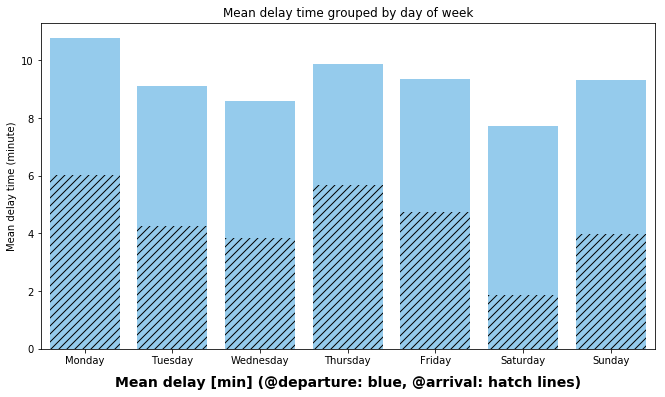

In [16]:
df = flights.copy()
fig = plt.figure(1, figsize=(11,6))
ax = sns.barplot(y="DEPARTURE_DELAY", x="DAY_OF_WEEK", data=df, color="lightskyblue", ci=None)
ax = sns.barplot(y="ARRIVAL_DELAY", x="DAY_OF_WEEK", data=df, color="r", hatch = '///',
                 alpha = 0.0, ci=None)
labels = [week_dict[item.get_text()] for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
#ax.yaxis.label.set_visible(False)
plt.xlabel('Mean delay [min] (@departure: blue, @arrival: hatch lines)',
           fontsize=14, weight = 'bold', labelpad=10);
plt.ylabel('Mean delay time (minute)')
plt.title('Mean delay time grouped by day of week')

3. Next we plotted averaged delay time of different month. Generally, there is a fluctuation in season (spring and autumn(Feburary, March, April and September, October, November) have shorter delay time while rest have longer time). And June and December have highest delay time, which may be explained by summer holiday and Christmas.

In [18]:
month_dict = {'1':'Jan','2':"Feb",'3':'Mar','4':'Apr','5':'May',
            '6':'Jun','7':'Jul','8':'Aug','9':'Sep','10':'Oct',
             '11':'Nov','12':'Dec'}

Text(0.5,1,'Mean delay time grouped by month')

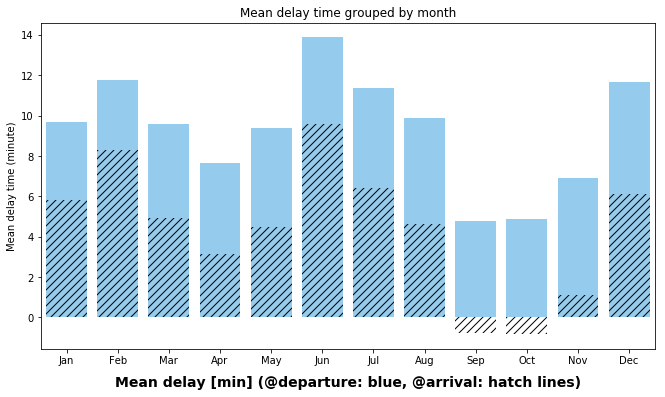

In [20]:
df = flights.copy()
fig = plt.figure(1, figsize=(11,6))
ax = sns.barplot(y="DEPARTURE_DELAY", x="MONTH", data=df, color="lightskyblue", ci=None)
ax = sns.barplot(y="ARRIVAL_DELAY", x="MONTH", data=df, color="r", hatch = '///',
                 alpha = 0.0, ci=None)
labels = [month_dict[item.get_text()] for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
# ax.yaxis.label.set_visible(False)
plt.xlabel('Mean delay [min] (@departure: blue, @arrival: hatch lines)',
           fontsize=14, weight = 'bold', labelpad=10);
plt.ylabel('Mean delay time (minute)')
plt.title('Mean delay time grouped by month')

4. Next we plotted the delay time differences of different departure city/state. Because there are too many cities, for the sake of clearness, here we just plotted top 15 busiest cities and their averaged delay time.

In [23]:
city_names = flights.DEPARTURE_CITY.value_counts().head(15).index
city_names

Index(['Chicago', 'Atlanta', 'Dallas-Fort Worth', 'Houston', 'Denver',
       'Los Angeles', 'New York', 'San Francisco', 'Phoenix', 'Las Vegas',
       'Minneapolis', 'Seattle', 'Orlando', 'Detroit', 'Boston'],
      dtype='object')

Text(0.5,1,'Mean delay time grouped by month')

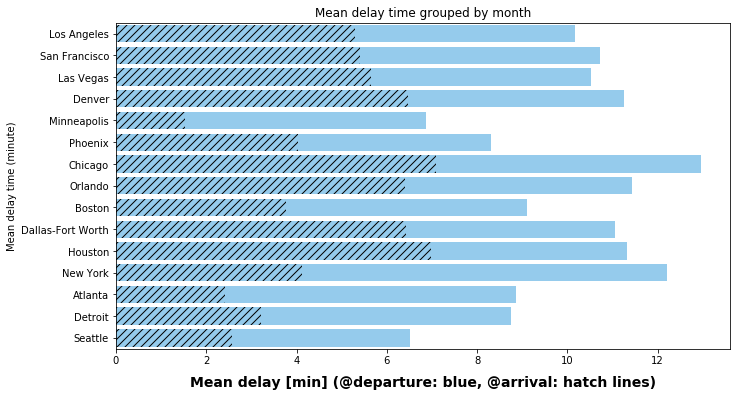

In [24]:
df_city = flights.copy()
df = df_city[df_city['DEPARTURE_CITY'].isin(city_names)]
fig = plt.figure(1, figsize=(11,6))
ax = sns.barplot(x="DEPARTURE_DELAY", y="DEPARTURE_CITY", data=df, color="lightskyblue", ci=None)
ax = sns.barplot(x="ARRIVAL_DELAY", y="DEPARTURE_CITY", data=df, color="r", hatch = '///',
                 alpha = 0.0, ci=None)
plt.xlabel('Mean delay [min] (@departure: blue, @arrival: hatch lines)',
           fontsize=14, weight = 'bold', labelpad=10);
plt.ylabel('Mean delay time (minute)')
plt.title('Mean delay time grouped by month')

And we showed the delay time differences in all US states.

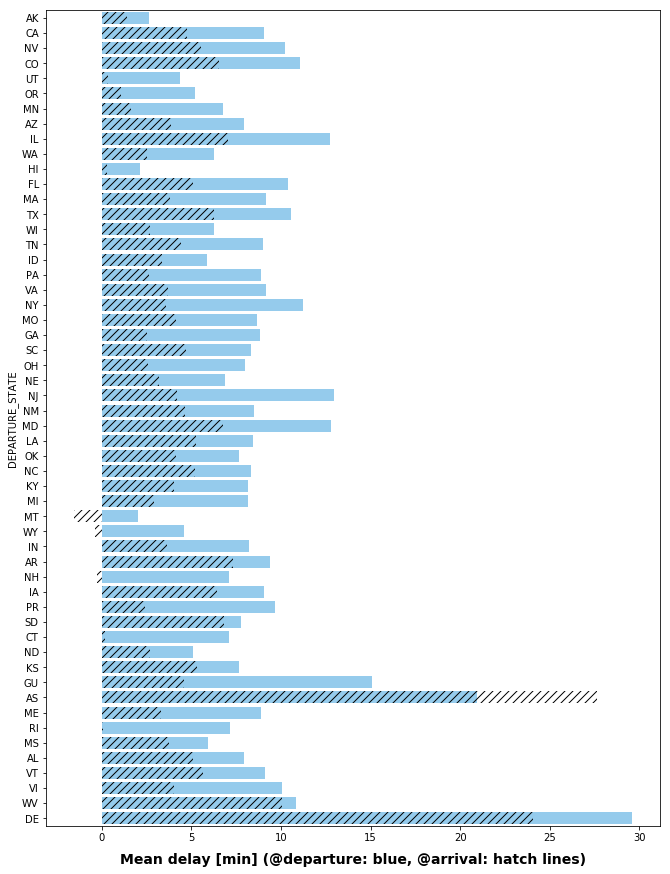

In [15]:
df = flights.copy()
fig = plt.figure(1, figsize=(11,15))
ax = sns.barplot(x="DEPARTURE_DELAY", y="DEPARTURE_STATE", data=df, color="lightskyblue", ci=None)
ax = sns.barplot(x="ARRIVAL_DELAY", y="DEPARTURE_STATE", data=df, color="r", hatch = '///',
                 alpha = 0.0, ci=None)
# labels = [abbr_companies[item.get_text()] for item in ax.get_yticklabels()]
# ax.set_yticklabels(labels)
# ax.yaxis.label.set_visible(False)
plt.xlabel('Mean delay [min] (@departure: blue, @arrival: hatch lines)',
           fontsize=14, weight = 'bold', labelpad=10);

5. Finally, we plotted the delay time over time of a day. And it is interesting that the delay time grows gradually after 5 am and slowly drops after 20pm. It reflects in the reality, that morning flights are less likely to be delayed, while later flights, because of delay of former flights, will be more likely to be delayed.

In [31]:
def hr_func(ts):
    return ts.hour
df = flights.copy()
df['time_hour'] = df['SCHEDULED_DEPARTURE'].apply(hr_func)

Text(0.5,1,'Mean delay grouped by departure hour')

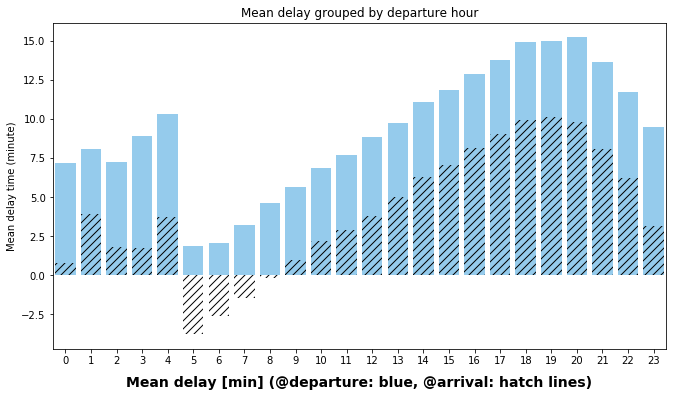

In [32]:
df = flights.copy()
fig = plt.figure(1, figsize=(11,6))
ax = sns.barplot(y="DEPARTURE_DELAY", x="time_hour", data=df, color="lightskyblue", ci=None)
ax = sns.barplot(y="ARRIVAL_DELAY", x="time_hour", data=df, color="r", hatch = '///',
                 alpha = 0.0, ci=None)
# labels = [month_dict[item.get_text()] for item in ax.get_xticklabels()]
# ax.set_xticklabels(labels)
# ax.yaxis.label.set_visible(False)
plt.xlabel('Mean delay [min] (@departure: blue, @arrival: hatch lines)',
           fontsize=14, weight = 'bold', labelpad=10);
plt.ylabel('Mean delay time (minute)')
plt.title('Mean delay grouped by departure hour')

Also, we noticed that different airlines have their preferred cities, which incide with their focus cities.

In [34]:
# HA for Hawaiian Airlines Inc.
flights.loc[flights.AIRLINE=='HA'].DEPARTURE_CITY.value_counts().head()

Honolulu       32828
Kahului        14014
Kailua/Kona     7939
Lihue           7884
Hilo            5932
Name: DEPARTURE_CITY, dtype: int64

In [33]:
# WN for Southwest Airlines Co.
flights.loc[flights.AIRLINE=='WN'].DEPARTURE_CITY.value_counts().head()

Chicago      81364
Las Vegas    74226
Baltimore    68427
Denver       60278
Phoenix      58010
Name: DEPARTURE_CITY, dtype: int64

---
Go back to [Table of contents](#Table-of-contents)

---

## Data Exploitation
In this part, we mainly performed:

1. clustering on whether an airport is averaged to delay (not delay for label -1, delay for label 1);
2. do machine learning regression to predict delay time in minutes.

First we defined the averaged delay time of each airports. It was calculated as follow: for specific airport, we calculated the mean arrival delay of all flights starting from it, and defined that delay time < 10 minutes as 'not delay'(labelled as -1), otherwise we labelled as 1.

- [Clutstering](#Clustering)
And for clustering we tried different methods, including:

1. [K means clustering](#K-means-clustering);
2. [Spectral graph clustering](#Spectral-Graph-Clustering);
3. [Transductive learning](#Transductive-Learning)

And the accuracy for these three methods were 64.3%(5 clusters), 69.4%(threshold eigenvalue is0.004) and 72.3%(recovering from 30% data)

Then we used more features (including month, day of week, hour of day, airline, departure and arrival airport) to set up machine learning model.

- [Machine Learning](#Machine-Learning)

Next we set up machine learning model based on decision tree and used this model to predict delay time of certain flights. We used LightGBM, which is a gradient boosting framework that uses tree based learning algorithms. And for features we used departure date, hour, airport, destination airport, air time and distance.

In this part we included:

1. [Data preprocessing](#Data-preprocessing)
2. [Building the model](#Building-the-model)
3. [Hyperparameter tuning](#Hyperparameter-tuning)
4. [Recommendation system](#Recommendation-system)

After model building and hyperparameter tuning, we got a model with prediction rmse = 2.3 (minutes), which worked quite well.
In this part we showed our recommendation system on how to give advice choosing flights. Given departure date and airports, our recommendation system will return the best combination of airline and departure time, and also the predicted delay minutes. For example, if we want to fly from New York to Chicago on 2019-07-21, our system will return best combination of departure time and airline and predicted delay time.

---
Go back to [Table of contents](#Table-of-contents)

---

## Clustering

### K means Clustering
This part used flight delay data on 2015 Jun. We created a graph using same method metioned above, except here we only used US data. 

In [3]:
pos_dict = {}
for i in range(len(airports)):
    pos_dict[airports.IATA_CODE[i]] = airports.LONGITUDE[i],airports.LATITUDE[i]

In [4]:
df = flights[['MONTH','ORIGIN_AIRPORT','DESTINATION_AIRPORT','DEPARTURE_DELAY','ARRIVAL_DELAY','AIR_TIME','DISTANCE']]

In [5]:
df1 = df.loc[df.MONTH==6].copy()
df2 = df1.groupby(['ORIGIN_AIRPORT','DESTINATION_AIRPORT'])['DEPARTURE_DELAY','ARRIVAL_DELAY','AIR_TIME','DISTANCE'].mean()
df2.reset_index(inplace=True)

df2['weight'] = df2.DISTANCE
df2.weight = df2.weight.clip_upper(2000)
df2.weight=(df2.weight-df2.weight.min())/(df2.weight.max()-df2.weight.min())

delta = 0.5
df2.weight = np.exp(-np.square(df2.weight)/delta)


In [6]:
G=nx.from_pandas_edgelist(df2, 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', edge_attr='weight')

In [7]:
node_col = G.nodes
label_df = pd.DataFrame(columns=node_col).append(df2.groupby(['ORIGIN_AIRPORT'])['DEPARTURE_DELAY','ARRIVAL_DELAY'].mean().T,sort=False).T
label_df.ARRIVAL_DELAY = label_df.ARRIVAL_DELAY-10
label_df.ARRIVAL_DELAY = label_df.ARRIVAL_DELAY.clip_upper(-1*np.min(label_df.ARRIVAL_DELAY))
label_df.head()

,DEPARTURE_DELAY,ARRIVAL_DELAY
ABE,12.595216,3.050936
ATL,14.348884,-1.562118
DTW,12.056992,-2.587865
ORD,19.658550,6.241072
ABI,10.509709,0.538835


In [8]:
label_geo_df = pd.merge(label_df,airports.set_index('IATA_CODE'),left_index=True,right_index=True)

In [9]:
L = nx.normalized_laplacian_matrix(G)
e, U = sparse.linalg.eigsh(L, k=10, which='SA')

Next plot shows the first 10 eigenvalues. Calculating the eigenvalues and plotting them, we noticed the eigenvalues after index 5 keep almost stable and the curve is flat, which implies 5 clusters in our data, so we choose 5 as the number of classes.

Text(0.5,1,'top 10 eigenvalue')

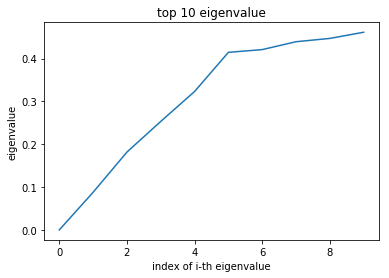

In [10]:
plt.plot(e)
plt.xlabel('index of i-th eigenvalue')
plt.ylabel('eigenvalue')
plt.title('top 10 eigenvalue')

The first 5 eigenvectors are extracted to form our sample matrix. Each row of the matrix is the feature vector for each node. Then we perform the k-means algorithm on these samples and the results are shown. All the nodes are embedded on the 2-dimensional plane and the color represent the corresponding class. In the bottom plot, we zoom in the left part and observe this largest cluster can be divided into two classes, which might provide some important information. 

In [11]:
# we used top 5 eigenvectors as our features
X = U[:,0:5]

k_means = KMeans(init='k-means++', n_clusters=5, n_init=10)
k_means.fit(X)

k_means_cluster_centers = np.sort(k_means.cluster_centers_, axis=0)
k_means_labels = pairwise_distances_argmin(X, k_means_cluster_centers)

(-0.02, 0.03)

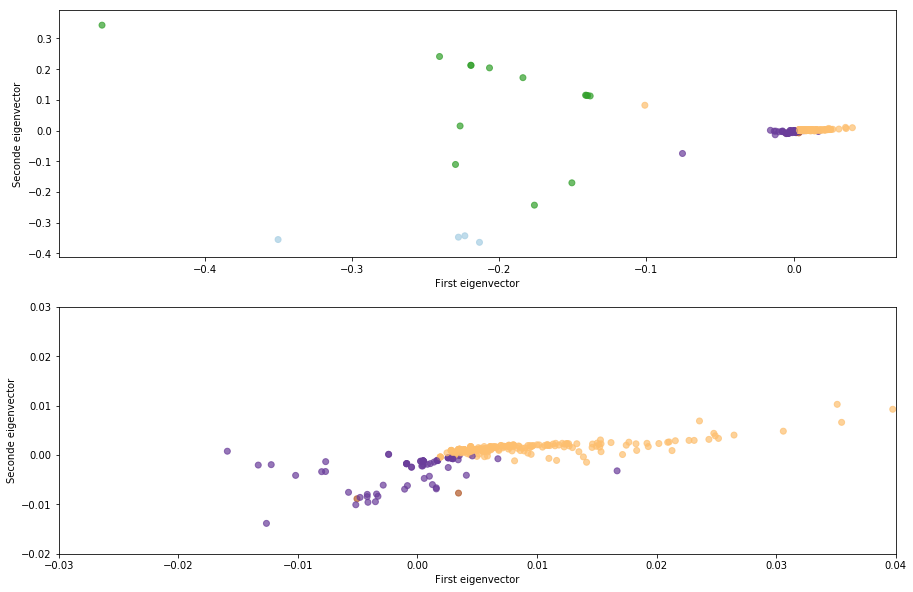

In [12]:
cmap = plt.get_cmap('Paired',5)

fig, ax = plt.subplots(2,1,figsize=(15,10))
ax[0].scatter(U[:,1],U[:,2],c=k_means_labels,alpha=0.7,cmap=cmap)
ax[0].set_xlabel('First eigenvector')
ax[0].set_ylabel('Seconde eigenvector')
#plt.colorbar()
ax[1].scatter(U[:,1],U[:,2],c=k_means_labels,alpha=0.7,cmap=cmap)
ax[1].set_xlabel('First eigenvector')
ax[1].set_ylabel('Seconde eigenvector')
ax[1].set_xlim(-0.03,0.04)
ax[1].set_ylim(-0.02,0.03)


Next plot (right) shows the delay distribution of all airports on the map. Airports in the west coast and east coast have different delay patterns. Arrival delays in the west coast airports are lower than delays in the east coast airports. 

For better data visualization, the clustering result is shown in next plot(Left) and all the nodes are positioned corresponding to their geographical positions. There is a close relationship between the result of clusters and the delay time for each airport.

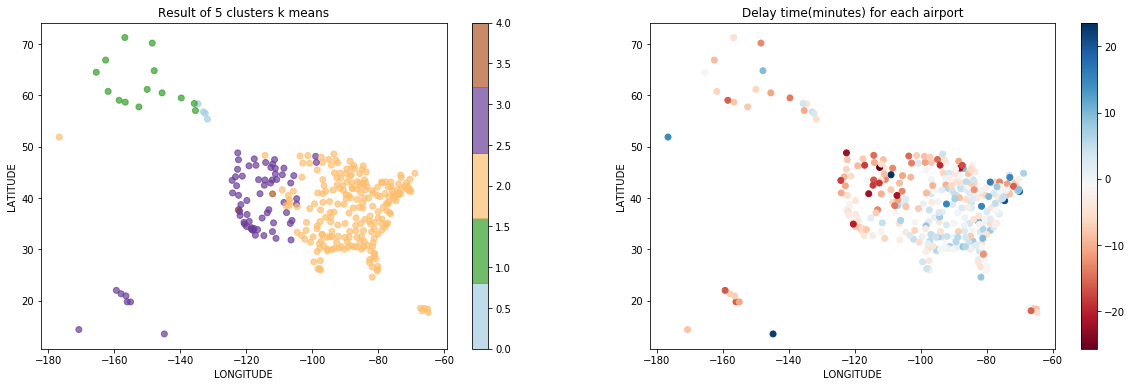

In [13]:
fig, ax = plt.subplots(1,2,figsize=(20,6))
im0 = ax[0].scatter(y=label_geo_df.LATITUDE,x=label_geo_df.LONGITUDE,
                    c=k_means_labels,cmap=cmap,alpha=0.7)
ax[0].set_ylabel('LATITUDE')
ax[0].set_xlabel('LONGITUDE')
ax[0].set_title('Result of 5 clusters k means')
#plt.colorbar()

im1 = ax[1].scatter(y=label_geo_df.LATITUDE,x=label_geo_df.LONGITUDE,
                    c=label_geo_df.ARRIVAL_DELAY,cmap='RdBu')

ax[1].set_ylabel('LATITUDE')
ax[1].set_xlabel('LONGITUDE')
ax[1].set_title('Delay time(minutes) for each airport')

fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])


In [98]:
binary_class = k_means_labels[np.logical_or((k_means_labels==3),(k_means_labels==2))]
delay_class = np.array(label_geo_df.ARRIVAL_DELAY)[np.logical_or((k_means_labels==3),(k_means_labels==2))]

In [99]:
delay_class = (delay_class>np.median(delay_class)).astype(np.int)

In [129]:
binary_class[binary_class==3]=0
binary_class[binary_class==2]=1
print('accuracy between k-means result and delay', np.mean(binary_class==delay_class))

accuracy between k-means result and delay 0.6428571428571429


### Spectral Graph Clustering
We embedded our nodes on the 2D plane using first and second eigenvectors as axes, with delayed(1) or not delayed (0) as our label.

By zooming in the right part of the 2D embedding, we can find an obvious threshold 0.004 in the first eigenvector. And we used e1 = 0.004 as the threshold (nodes with e1 smaller than 0.004 will be predicted as 0; otherwise 1). And compared the result with ground truth, we got accuracy of 69.4%.

In [106]:
bin_delay = (label_geo_df.ARRIVAL_DELAY>np.median(label_geo_df.ARRIVAL_DELAY)).astype(np.int)

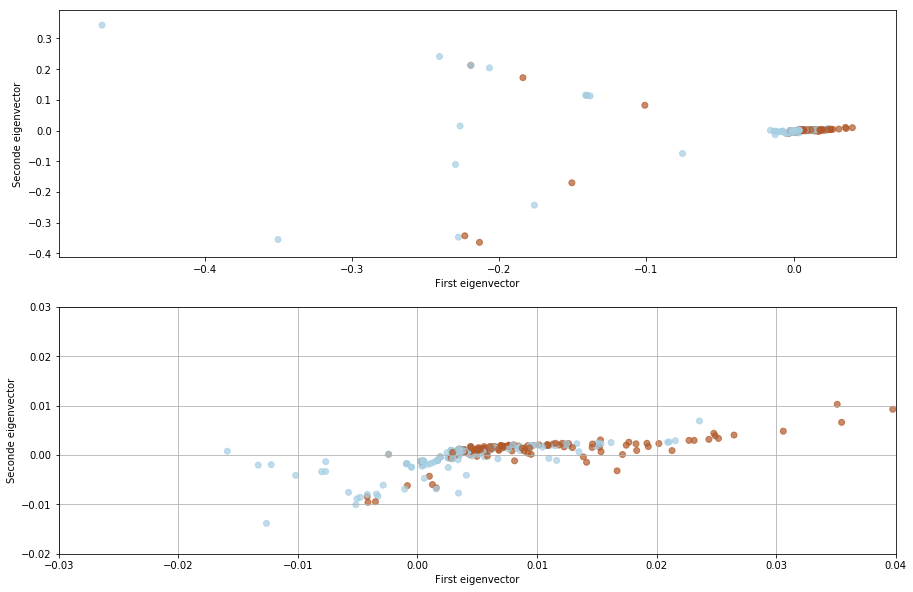

In [131]:
cmap = plt.get_cmap('Paired',2)

fig, ax = plt.subplots(2,1,figsize=(15,10))
ax[0].scatter(U[:,1],U[:,2],c=bin_delay,alpha=0.7,cmap=cmap)
ax[0].set_xlabel('First eigenvector')
ax[0].set_ylabel('Seconde eigenvector')

#plt.colorbar()
ax[1].scatter(U[:,1],U[:,2],c=bin_delay,alpha=0.7,cmap=cmap)
ax[1].set_xlabel('First eigenvector')
ax[1].set_ylabel('Seconde eigenvector')
ax[1].set_xlim(-0.03,0.04)
ax[1].set_ylim(-0.02,0.03)
ax[1].grid(True)

In [116]:
bin_class = (U[:,1]>0.004).astype(np.int)

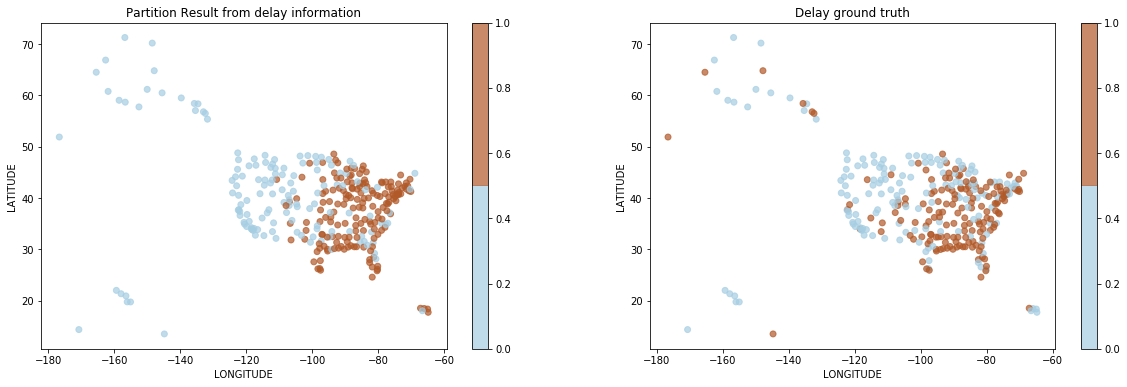

In [127]:
fig, ax = plt.subplots(1,2,figsize=(20,6))
im0 = ax[0].scatter(y=label_geo_df.LATITUDE,x=label_geo_df.LONGITUDE,
                    c=bin_class,cmap=cmap,alpha=0.7)
ax[0].set_ylabel('LATITUDE')
ax[0].set_xlabel('LONGITUDE')
ax[0].set_title('Partition Result from delay information')

im1 = ax[1].scatter(y=label_geo_df.LATITUDE,x=label_geo_df.LONGITUDE,
                    c=bin_delay,cmap=cmap,alpha=0.7)

ax[1].set_ylabel('LATITUDE')
ax[1].set_xlabel('LONGITUDE')
ax[1].set_title('Delay ground truth')

fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])

In [128]:
print('accuracy between partion result and delay ground truth',np.mean(bin_class==bin_delay))

accuracy between partion result and delay ground truth 0.6942675159235668


---
Go back to [Table of contents](#Table-of-contents)

---

### Transductive Learning
In this part we used `Transductive Learning` to do clustering and gave some sense in recovering the whole world delay signal.

In [15]:
def transductive_learning(df,delta,bias,proportion=0.3):
    """
    This function is used to calculate the accuracy of transductive learning for given data.
    
    parameters:
        df: dataframe containing airport information.
        delta: parameter for calculating weights in Gaussion kernel.
        bias: bias for defining 'delay'.
        proportion: proportion of known data.
    
    return:
        accuracy using gradient 1 norm and 2 norm minimization.
    """
    max_iter = 10
    acc1 = []
    acc2 = []
    
    df = df.copy()
    df['weight'] = df.DISTANCE.copy()
    df.weight = df.weight.clip_upper(2000)
    df.weight=(df.weight-df.weight.min())/(df.weight.max()-df.weight.min())    
    df.weight = np.exp(-np.square(df.weight)/delta)

    G=nx.from_pandas_edgelist(df2, 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', edge_attr='weight')
    adjacency = nx.to_numpy_array(G)

    node_col = G.nodes
    label_df = pd.DataFrame(columns=node_col).append(df2.groupby(['ORIGIN_AIRPORT'])['DEPARTURE_DELAY','ARRIVAL_DELAY'].mean().T,sort=False).T
    label_df.ARRIVAL_DELAY = label_df.ARRIVAL_DELAY-bias
    # label_df.ARRIVAL_DELAY = label_df.ARRIVAL_DELAY.clip_upper(-1*np.min(label_df.ARRIVAL_DELAY))
    # label_df.head()

    label_geo_df = pd.merge(label_df,airports.set_index('IATA_CODE'),left_index=True,right_index=True)

    global labels_bin 
    labels_bin = label_geo_df.ARRIVAL_DELAY.get_values().copy()#.reshape(-1,1)
    threshold = 0
    labels_bin = (labels_bin>threshold).astype(np.int)
    labels_bin = 2*labels_bin - 1
    
    gradient_matrix_T = sparse.csr_matrix(compute_gradient_matrix(adjacency))

    n_nodes = adjacency.shape[0]
    mn_ratio = proportion
    m = int(mn_ratio * n_nodes)  # Number of measurements.
    
    #for i in range(max_iter):
    
    random_index = np.random.permutation(n_nodes)
    subsample = random_index[:m]

    # Compute measurement mask vector w
    global w 
    w = np.zeros(n_nodes)
    w[subsample]=1

    sol_1norm_min = graph_pnorm_interpolation(gradient_matrix_T, P,x0=np.random.randn(n_nodes), p=1.)

    sol_2norm_min = graph_pnorm_interpolation(gradient_matrix_T, P,x0=np.random.randn(n_nodes), p=2.)

    sol_1norm_bin = sol_1norm_min.copy()
    sol_1norm_bin = (sol_1norm_bin>threshold).astype(np.int)
    sol_1norm_bin = 2*sol_1norm_bin - 1

    sol_2norm_bin = sol_2norm_min.copy()
    sol_2norm_bin = (sol_2norm_bin>threshold).astype(np.int)
    sol_2norm_bin = 2*sol_2norm_bin - 1

    rel_err1 = rel_err(labels_bin,sol_1norm_bin)
    rel_err2 = rel_err(labels_bin,sol_2norm_bin)

    acc1_tmp = np.sum(labels_bin==sol_1norm_bin)/len(labels_bin)
    acc2_tmp = np.sum(labels_bin==sol_2norm_bin)/len(labels_bin)

    acc1.append(acc1_tmp)
    acc2.append(acc2_tmp)
    print('Parameters: ',delta,bias,'Accuracy: ',np.mean(acc1),np.mean(acc2))
    return sol_1norm_bin,sol_2norm_bin


We first tried to find out the best parameter.

In [11]:
delta_s = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

In [22]:
for delta in delta_s:
    transductive_learning(df=df2,delta=delta,bias=10,proportion=0.3)

Parameters:  0.1 10 Accuracy:  0.6401273885350318 0.6496815286624203
Parameters:  0.2 10 Accuracy:  0.6910828025477707 0.6050955414012739
Parameters:  0.3 10 Accuracy:  0.643312101910828 0.6656050955414012
Parameters:  0.4 10 Accuracy:  0.6401273885350318 0.6751592356687898
Parameters:  0.5 10 Accuracy:  0.6942675159235668 0.6496815286624203
Parameters:  0.6 10 Accuracy:  0.6942675159235668 0.6656050955414012
Parameters:  0.7 10 Accuracy:  0.6496815286624203 0.6464968152866242
Parameters:  0.8 10 Accuracy:  0.6369426751592356 0.643312101910828
Parameters:  0.9 10 Accuracy:  0.6751592356687898 0.6687898089171974
Parameters:  1 10 Accuracy:  0.6464968152866242 0.6719745222929936


In [69]:
# highest accuracy occurs when delta = 0.5
delta = 0.5
norm1_label, norm2_label = transductive_learning(df=df2,delta=delta,bias=10,proportion=0.3)

Parameters:  0.5 10 Accuracy:  0.7229299363057324 0.6656050955414012


In [70]:
df2['weight'] = df2.DISTANCE.copy()
df2.weight = df2.weight.clip_upper(2000)
df2.weight=(df2.weight-df2.weight.min())/(df2.weight.max()-df2.weight.min())
df2.weight = np.exp(-np.square(df2.weight)/delta)

In [71]:
G=nx.from_pandas_edgelist(df2, 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', edge_attr='weight')

node_col = G.nodes
label_df = pd.DataFrame(columns=node_col).append(df2.groupby(['ORIGIN_AIRPORT'])['DEPARTURE_DELAY','ARRIVAL_DELAY'].mean().T,sort=False).T
label_df.ARRIVAL_DELAY = label_df.ARRIVAL_DELAY-10
label_df.ARRIVAL_DELAY = label_df.ARRIVAL_DELAY.clip_upper(-1*np.min(label_df.ARRIVAL_DELAY))

label_geo_df = pd.merge(label_df,airports.set_index('IATA_CODE'),left_index=True,right_index=True)

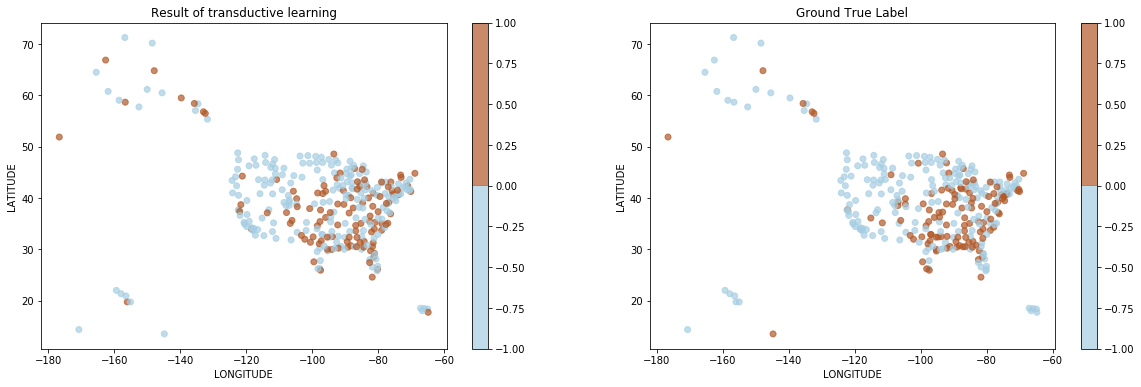

In [72]:
cmap = plt.get_cmap('Paired',2)

fig, ax = plt.subplots(1,2,figsize=(20,6))
im0 = ax[0].scatter(y=label_geo_df.LATITUDE,x=label_geo_df.LONGITUDE,
                    c=norm1_label,cmap=cmap,alpha=0.7)
ax[0].set_ylabel('LATITUDE')
ax[0].set_xlabel('LONGITUDE')
ax[0].set_title('Result of transductive learning')
#plt.colorbar()


labels_bin = label_geo_df.ARRIVAL_DELAY.get_values().copy()#.reshape(-1,1)
threshold = 0
labels_bin = (labels_bin>np.median(threshold)).astype(np.int)
labels_bin = 2*labels_bin - 1

im1 = ax[1].scatter(y=label_geo_df.LATITUDE,x=label_geo_df.LONGITUDE,
                    c=labels_bin,cmap=cmap,alpha = 0.7)

ax[1].set_ylabel('LATITUDE')
ax[1].set_xlabel('LONGITUDE')
ax[1].set_title('Ground True Label')

fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])


We can see that using 30% data can recover the US whole data quite well. Then we wanted to know if we can recover the whole world delay data using this method.

In [61]:
US_p = len(portgeo.loc[portgeo.Country=='United States'])/len(portgeo)
US_p = np.round(US_p*100,3)
print('The percentage of the US airports over all airports in OpenFlight data set is:',US_p,'%')

The percentage of the US airports over all airports in OpenFlight data set is: 13.961 %


In [57]:
norm1_label, norm2_label = transductive_learning(df=df2,delta=0.5,bias=10,proportion=0.13)

Parameters:  0.5 10 Accuracy:  0.5445859872611465 0.5605095541401274


We can see that using only 13.961% data to recover the whole dataset is not very useful. The US airports only take very small percentage of the whole world, so it is unwise to recover whole world data based on our graph.

---
Go back to [Table of contents](#Table-of-contents)

---

## Machine Learning
Next we set up machine learning model based on decision tree and used this model to predict delay time of certain flights. We used LightGBM, which is a gradient boosting framework that uses tree based learning algorithms. And for features we used departure date, hour, airport, destination airport, air time and distance.

In this part we included:

1. [Data preprocessing](#Data-preprocessing)
2. [Building the model](#Building-the-model)
3. [Hyperparameter tuning](#Hyperparameter-tuning)
4. [Recommendation system](#Recommendation-system)

After model building and hyperparameter tuning, we got a model with prediction rmse = 2.3 (minutes), which worked quite well.
In this part we showed our recommendation system on how to give advice choosing flights. Given departure date and airports, our recommendation system will return the best combination of airline and departure time, and also the predicted delay minutes. For example, if we want to fly from New York to Chicago on 2019-07-21, following showed the best combination of features with lowest delay time (minus minute means arriving earlier than scheduled arrival time.

---
Go back to [Table of contents](#Table-of-contents)

---

### Data prepocessing
In this part we pre-processed our data set.

1. Normalize `DISTANCE` and `AIR_TIME`;
2. Created new features: `DAY_OFWEEK`,`DAY_OF_YEAR`,`WEEK_OF_YEAR`.

Taking the `DAY` as an example, whether that day is weekday matters. The passenger flow on the weekdays is greatly higher than that on weekends, as there are many business trips. Similarly, the position of the week in a year also contains passenger flow information. People are likely to travel in summer vacation. As the result of increasing passenger flow, the probability of flight delay ascends. Using this analysis, we generated three additional features: `DAY_OFWEEK`,`DAY_OF_YEAR`,`WEEK_OF_YEAR`.

In [3]:
feature = pd.read_pickle('used_feature.pkl') # Load the feature dataset
label = pd.read_pickle('used_label.pkl') # Load corresponding labels

In [4]:
'''
Reset the index of dataset
'''
feature.reset_index(inplace=True) 
feature.drop(columns=['index'], inplace=True)
label = label.reset_index()
label.drop(columns=['index'], inplace=True)

In [5]:
'''
Drop the significant outliers
'''
drop_idx_1 = label.index[label.ARRIVAL_DELAY >= 30]
drop_idx_2 = label.index[label.ARRIVAL_DELAY <= -30]
drop_idx = drop_idx_1.union(drop_idx_2)
feature.drop(index=drop_idx, inplace=True)
label.drop(index=drop_idx, inplace=True)

In [6]:
'''
Randomly sample data from the whole dataset to reduce model training consumption
'''
feature = feature.sample(frac=0.02, random_state=8)
label = label.sample(frac=0.02, random_state=8)

In [7]:
'''
Category index should be positive
'''
feature.ORIGIN_AIRPORT += 2
feature.DESTINATION_AIRPORT += 2

In [8]:
'''
Normalize the feature with mean and standard deviation
'''
scaler = StandardScaler().fit(feature.iloc[:,-2:])
feature.iloc[:,-2:] = scaler.transform(feature.iloc[:,-2:])

/Users/wentao/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/wentao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


In [27]:
'''
Train-test split
'''
train_set, test_set, train_label, test_label = train_test_split(feature, label, test_size = 0.2, random_state = 8)

In [11]:
feature.head()

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,DAY_OF_YEAR,WEEK_OF_YEAR,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DISTANCE,AIR_TIME
4024004,9,13,7,9,256,37,41,184,13,-1.043928,-0.964847
490797,2,3,2,0,34,6,230,289,15,1.638574,2.068381
1514643,4,10,5,6,100,15,270,238,18,0.214177,0.310810
4702513,10,26,1,9,299,44,231,22,16,-0.486263,-0.355367
4399632,10,7,3,1,280,41,68,178,11,2.216395,2.252643


In [12]:
label.head()

,ARRIVAL_DELAY
4024004,-7.0
490797,1.0
1514643,-1.0
4702513,-14.0
4399632,-13.0


### Building the model
In this part we built the model and created features used in LightGBM.

In [13]:
def rmse(y_true, y_pred):
# Calculate the root mean square error for two arrays
# Input: true value, predicted value
# Output: Root mean square error
    y_true_disc = np.ceil(y_true / 5)
    y_pred_disc = np.ceil(y_pred / 5)
    rmse = np.sqrt(metrics.mean_squared_error(y_true_disc, y_pred_disc))
    return rmse

In [14]:
def accuracy(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

In [15]:
scorer = {}
scorer['rmse'] = metrics.make_scorer(rmse, greater_is_better=False)
scorer['accuracy'] = metrics.make_scorer(accuracy, greater_is_better=True)
scorer

{'rmse': make_scorer(rmse, greater_is_better=False),
 'accuracy': make_scorer(accuracy)}

In [16]:
def model_validation(train_pred, test_pred):
    rmse_train = rmse(train_label, train_pred)
    rmse_test = rmse(test_label, test_pred)
    print("RMSE - train is {0:1.2f} and test is {1:1.2f}".format(rmse_train, rmse_test))

In [17]:
def CV_generator(feature_set, label_set, n_split = 8, test_ratio = 0.2):
    CV_ShuffleSplit = ShuffleSplit(n_splits=n_split, test_size=test_ratio, random_state=8)
    for train, test in CV_ShuffleSplit.split(feature, label):
        yield train, test

In [18]:
flight_lgb_reg = lgb.LGBMRegressor(boosting_type='gbdt', 
                                   random_state=8, n_jobs=-1, colsample_bytree=0.8, n_estimators = 200)

In [19]:
feature.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98683 entries, 4024004 to 1548947
Data columns (total 11 columns):
MONTH                  98683 non-null int64
DAY                    98683 non-null int64
DAY_OF_WEEK            98683 non-null int64
AIRLINE                98683 non-null int8
DAY_OF_YEAR            98683 non-null int64
WEEK_OF_YEAR           98683 non-null int64
ORIGIN_AIRPORT         98683 non-null int16
DESTINATION_AIRPORT    98683 non-null int16
SCHEDULED_DEPARTURE    98683 non-null int64
DISTANCE               98683 non-null float64
AIR_TIME               98683 non-null float64
dtypes: float64(2), int16(2), int64(6), int8(1)
memory usage: 7.2 MB


### Hyperparameter tuning
Then we performed grid search to find the best parametre.

1. First round for hyperparameter tuning

In [20]:
params_grid = {}
params_grid['learning_rate'] = [0.01, 0.05, 0.1]
params_grid['num_leaves'] = [130, 150]
params_grid['min_child_samples'] = [50, 100, 200]
params_grid['subsample'] = [0.3, 0.4, 0.5]
params_grid['max_depth'] = [int(x) for x in range(7, 10)]
params_grid['reg_lambda'] = [0.1, 1, 10]
params_grid['subsample_for_bin'] = [20000, 200000]
params_grid

{'learning_rate': [0.01, 0.05, 0.1],
 'num_leaves': [130, 150],
 'min_child_samples': [50, 100, 200],
 'subsample': [0.3, 0.4, 0.5],
 'max_depth': [7, 8, 9],
 'reg_lambda': [0.1, 1, 10],
 'subsample_for_bin': [20000, 200000]}

In [21]:
grid_search = GridSearchCV(flight_lgb_reg, params_grid, verbose=1, cv=6, n_jobs=-1, error_score=np.nan, 
                           return_train_score=True, scoring = scorer['rmse'])

In [22]:
grid_search.fit(feature, label, feature_name=feature.columns.tolist(), 
               categorical_feature=feature.columns[:-2].tolist())

Fitting 6 folds for each of 972 candidates, totalling 5832 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   46.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed: 23.3min
/Users/wentao/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed: 37.0min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed: 46.4min
/Users/wentao/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to th

GridSearchCV(cv=6, error_score=nan,
       estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=200, n_jobs=-1, num_leaves=31, objective=None,
       random_state=8, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'learning_rate': [0.01, 0.05, 0.1], 'num_leaves': [130, 150], 'min_child_samples': [50, 100, 200], 'subsample': [0.3, 0.4, 0.5], 'max_depth': [7, 8, 9], 'reg_lambda': [0.1, 1, 10], 'subsample_for_bin': [20000, 200000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(rmse, greater_is_better=False), verbose=1)

In [24]:
grid_search.best_params_

{'learning_rate': 0.1,
 'max_depth': 8,
 'min_child_samples': 50,
 'num_leaves': 130,
 'reg_lambda': 10,
 'subsample': 0.3,
 'subsample_for_bin': 20000}

In [25]:
best_param_1 = grid_search.best_params_
best_param_1

{'learning_rate': 0.1,
 'max_depth': 8,
 'min_child_samples': 50,
 'num_leaves': 130,
 'reg_lambda': 10,
 'subsample': 0.3,
 'subsample_for_bin': 20000}

In [26]:
grid_search.best_score_

-2.3290041634195586

In [31]:
test_est = grid_search.best_estimator_.fit(train_set, train_label)

In [32]:
train_pred = test_est.predict(train_set)
test_pred = test_est.predict(test_set)

2. Second round for hyperparameter

In [34]:
params_grid_2 = {}
params_grid_2['learning_rate'] = [0.5, 0.01, 0.1]
params_grid_2['num_leaves'] = [100, 130, 100]
params_grid_2['min_child_samples'] = [50, 10, 50]
params_grid_2['subsample'] = [0.3, 0.8]
params_grid_2['max_depth'] = [8]
params_grid_2['reg_lambda'] = [0.1]
params_grid_2['subsample_for_bin'] = [20000, 100000]
params_grid_2

{'learning_rate': [0.5, 0.01, 0.1],
 'num_leaves': [100, 130, 100],
 'min_child_samples': [50, 10, 50],
 'subsample': [0.3, 0.8],
 'max_depth': [8],
 'reg_lambda': [0.1],
 'subsample_for_bin': [20000, 100000]}

In [35]:
grid_search_2 = GridSearchCV(flight_lgb_reg, params_grid_2, verbose=1, cv=6, n_jobs=-1, error_score=np.nan, 
                           return_train_score=True, scoring = scorer['rmse'])

In [36]:
grid_search_2.fit(feature, label,feature_name=feature.columns.tolist(), 
                categorical_feature=feature.columns[:-2].tolist())

Fitting 6 folds for each of 108 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed: 12.7min finished
/Users/wentao/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['AIRLINE', 'DAY', 'DAY_OF_WEEK', 'DAY_OF_YEAR', 'DESTINATION_AIRPORT', 'MONTH', 'ORIGIN_AIRPORT', 'SCHEDULED_DEPARTURE', 'WEEK_OF_YEAR']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


GridSearchCV(cv=6, error_score=nan,
       estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=200, n_jobs=-1, num_leaves=31, objective=None,
       random_state=8, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'learning_rate': [0.5, 0.01, 0.1], 'num_leaves': [100, 130, 100], 'min_child_samples': [50, 10, 50], 'subsample': [0.3, 0.8], 'max_depth': [8], 'reg_lambda': [0.1], 'subsample_for_bin': [20000, 100000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(rmse, greater_is_better=False), verbose=1)

In [37]:
best_param_2 = grid_search_2.best_params_
best_param_2

{'learning_rate': 0.1,
 'max_depth': 8,
 'min_child_samples': 50,
 'num_leaves': 100,
 'reg_lambda': 0.1,
 'subsample': 0.3,
 'subsample_for_bin': 20000}

In [38]:
grid_search_2.best_score_

-2.329957524999022

In [39]:
final_model = grid_search_2.best_estimator_

3. Cross validation testing our parameters
We can see that our test error was reduced to 2.3 (minutes) and our model was working well.

In [45]:
idx = 0
for train_idx, test_idx in CV_generator(feature, label, 16, test_ratio=0.2):
    train_feature = feature.iloc[train_idx]
    train_label = label.iloc[train_idx]
    test_feature = feature.iloc[test_idx]
    test_label = label.iloc[test_idx]
    trained_model = final_model.fit(train_feature, train_label)
    train_pred = trained_model.predict(train_feature)
    test_pred = trained_model.predict(test_feature)
    print(idx)
    if idx == 7:
        final_trained_model = trained_model
        train_feature_set = train_feature
        train_label_set = train_label
        test_feature_set = test_feature
        test_label_set = test_label
        joblib.dump(final_trained_model,'final_model.joblib')
    model_validation(train_pred, test_pred)
    print('\n')
    idx += 1

0
RMSE - train is 2.12 and test is 2.29


1
RMSE - train is 2.11 and test is 2.32


2
RMSE - train is 2.12 and test is 2.30


3
RMSE - train is 2.12 and test is 2.30


4
RMSE - train is 2.12 and test is 2.31


5
RMSE - train is 2.12 and test is 2.30


6
RMSE - train is 2.12 and test is 2.29


7
RMSE - train is 2.12 and test is 2.28


8
RMSE - train is 2.13 and test is 2.29


9
RMSE - train is 2.11 and test is 2.32


10
RMSE - train is 2.12 and test is 2.30


11
RMSE - train is 2.11 and test is 2.33


12
RMSE - train is 2.12 and test is 2.32


13
RMSE - train is 2.13 and test is 2.30


14
RMSE - train is 2.12 and test is 2.29


15
RMSE - train is 2.11 and test is 2.31




Below we showed the feature importance. We  can  conclude that  the  travel  distance  and  travel  time  have  a  critical  im-pact  on  the  possibility  of  delay.  Meanwhile,  the  importance of DAY_OF_YEARalso  proves  that  our  analysis  on  feature generation is reasonable.

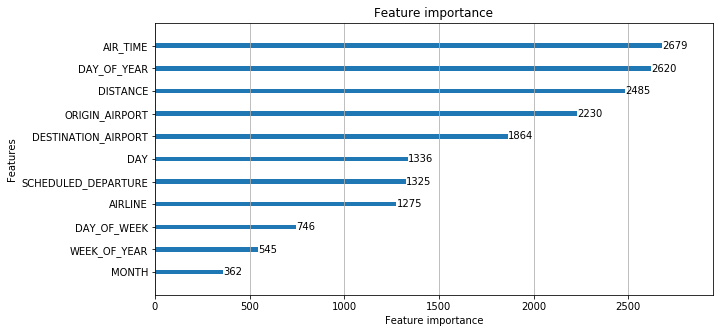

In [71]:
ax = lgb.plot_importance(final_trained_model, figsize=(10,5), importance_type='split')
ax.grid(axis = 'y')
plt.savefig('import.pdf', bbox_inches='tight')

### Recommendation system
In this part we showed our recommendation system on how to give advice choosing flights. Given departure date and airports, our recommendation system will return the best combination of airline and departure time, and also the predicted delay minutes.
For example, if we want to fly from New York to Chicago on 2019-07-21, following showed the best combination of features with lowest delay time (minus minute means arriving earlier than scheduled arrival time).

In [363]:
def recommend_trip(YEAR_input, MONTH_input, DAY_input, DEPARTURE_input, DESTINATION_input):
    YEAR = YEAR_input
    MONTH = MONTH_input
    DAY = DAY_input
    date = datetime.datetime(YEAR, MONTH, DAY)
    DAY_OF_WEEK = date.weekday() + 1
    AIRLINE = np.nan
    DAY_OF_YEAR = date.timetuple().tm_yday
    WEEK_OF_YEAR = date.isocalendar()[1]
    ORIGIN_AIRPORT = airports.index[airports.IATA_CODE == DEPARTURE_input][0]
    DESTINATION_AIRPORT = airports.index[airports.IATA_CODE == DEPARTURE_input][0]
    SCHEDULED_DEPARTURE = np.nan
    DISTANCE = np.nan
    AIR_TIME = np.nan

    feature_pred = np.array([MONTH, DAY, DAY_OF_WEEK, AIRLINE, DAY_OF_YEAR, WEEK_OF_YEAR, ORIGIN_AIRPORT, DESTINATION_AIRPORT, SCHEDULED_DEPARTURE, DISTANCE, AIR_TIME])
    feature_pred = np.tile(feature_pred, [336, 1])
    recommend_df = pd.DataFrame(feature_pred, columns=feature.columns)

    airline_idx = np.array(airlines.index)
    airline_idx = np.tile(airline_idx,[1,24])
    airline_idx = np.sort(airline_idx)
    recommend_df.loc[:,'AIRLINE'] = airline_idx.T
    hour = np.arange(0,24)
    hour = np.tile(hour, [1,14])
    recommend_df.loc[:,'SCHEDULED_DEPARTURE'] = hour.T

    pred_delay = final_trained_model.predict(recommend_df)
    min_delay = np.min(pred_delay)
    lower_bound = (np.ceil(min_delay / 5) -1) * 5
    upper_bound = np.ceil(min_delay / 5) * 5 
    min_delay_idx = np.argmin(pred_delay)
    prefer_airline = airlines.iloc[recommend_df.AIRLINE.iloc[min_delay_idx],1]
    prefer_hour = recommend_df.SCHEDULED_DEPARTURE.iloc[recommend_df.AIRLINE.iloc[min_delay_idx]]
    print(str(date.date()))
    print('From:', airports.AIRPORT[airports.IATA_CODE == DEPARTURE_input].item())
    print('To:', airports.AIRPORT[airports.IATA_CODE == DESTINATION_input].item())
    print('We recommend <', prefer_airline, '> at ', prefer_hour,' o\'clock', sep = '')
    print("Estimated delay is between {0:1.2f} min and {1:1.2f} min\n".format(lower_bound, upper_bound))
    return prefer_airline, prefer_hour
    

For example, if we want to fly from New York to Chicago on 2019-07-21, following showed the best combination of features with lowest delay time (minus minute means arriving earlier than scheduled arrival time.

In [334]:
_, _ = recommend_trip(YEAR_input, MONTH_input, DAY_input, 'LGA', 'ORD')

2019-07-21
From: LaGuardia Airport (Marine Air Terminal)
To: Chicago O'Hare International Airport

We recommend <United Air Lines Inc.> at 0 o'clock
Estimated delay is between -15.00 min and -10.00 min


In [335]:
_, _ = recommend_trip(YEAR_input, MONTH_input, DAY_input, 'LGA', 'MDW')

2019-07-21
From: LaGuardia Airport (Marine Air Terminal)
To: Chicago Midway International Airport

We recommend <United Air Lines Inc.> at 0 o'clock
Estimated delay is between -15.00 min and -10.00 min


In [336]:
_, _ = recommend_trip(YEAR_input, MONTH_input, DAY_input, 'JFK', 'ORD')

2019-07-21
From: John F. Kennedy International Airport (New York International Airport)
To: Chicago O'Hare International Airport

We recommend <American Eagle Airlines Inc.> at 12 o'clock
Estimated delay is between -15.00 min and -10.00 min
